# CEIA - NLP Desafío N°4
## Villanueva Cecilia Azul

## Procesamiento de Lenguaje Natural
### LSTM Bot QA


### Enunciado
El objecto es utilizar datos disponibles del challenge ConvAI2 (Conversational Intelligence Challenge 2) de conversaciones en inglés. Se construirá un BOT para responder a preguntas del usuario (QA).\
[LINK](http://convai.io/data/)

### Librerías

In [ ]:
#!pip install --upgrade --no-cache-dir gdown --quiet

In [1]:
import json
import logging
import os
import pickle
import re
from io import StringIO
from pathlib import Path

import gdown
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.text import Tokenizer, one_hot
from tensorflow.keras.utils import pad_sequences


from keras.callbacks import EarlyStopping, LearningRateScheduler
from keras.layers import (Activation, Bidirectional, Concatenate, Dense, Dropout,
                          Embedding, Flatten, Input, LSTM, SimpleRNN)
from keras.models import Model, Sequential
from keras.optimizers import Nadam
from keras.utils import plot_model, to_categorical


### 1 - Datos

In [2]:
# Descargar la carpeta de dataset
if os.access('data_volunteers.json', os.F_OK) is False:
    url = 'https://drive.google.com/uc?id=1awUxYwImF84MIT5-jCaYAPe2QwSgS1hN&export=download'
    output = 'data_volunteers.json'
    gdown.download(url, output, quiet=False)
else:
    print("El dataset ya se encuentra descargado")

Downloading...
From: https://drive.google.com/uc?id=1awUxYwImF84MIT5-jCaYAPe2QwSgS1hN&export=download
To: /content/data_volunteers.json
100%|██████████| 2.58M/2.58M [00:00<00:00, 19.2MB/s]


In [3]:
# dataset_file
text_file = "data_volunteers.json"
with open(text_file) as f:
    data = json.load(f) # la variable data será un diccionario

In [4]:
in_encoder_txt = []
in_decoder_txt = []
out_decoder_txt = []
max_len = 40

def clean_text(txt):
    txt = txt.lower()
    txt.replace("\'d", " had")
    txt.replace("\'s", " is")
    txt.replace("\'m", " am")
    txt.replace("don't", "do not")
    txt = re.sub(r'[\W_]+', ' ', txt)

    return txt

for line in data:
    for i in range(len(line['dialog'])-1):
        # vamos separando el texto en "preguntas" (chat_in)
        # y "respuestas" (chat_out)
        chat_in = clean_text(line['dialog'][i]['text'])
        chat_out = clean_text(line['dialog'][i+1]['text'])

        if len(chat_in) >= max_len or len(chat_out) >= max_len:
            continue

        in_encoder_txt.append(chat_in)
        in_decoder_txt.append('sostok ' + chat_out)
        out_decoder_txt.append(chat_out + ' eostok')

print("Number of lines:", len(in_encoder_txt))

Number of lines: 8630


In [5]:
in_encoder_txt[1], in_decoder_txt[1], out_decoder_txt[1]

('hi how are you ', 'sostok not bad and you ', 'not bad and you  eostok')

In [6]:
in_encoder_words = [word for sentence in in_encoder_txt for word in sentence.split()]
in_encoder_unique_words = set(in_encoder_words)
print("Number of words in encoder input:", len(in_encoder_unique_words))

in_decoder_words = [word for sentence in in_decoder_txt for word in sentence.split()]
in_decoder_unique_words = set(in_decoder_words)
print("Number of words in decoder input:", len(in_decoder_unique_words))

out_decoder_words = [word for sentence in out_decoder_txt for word in sentence.split()]
out_decoder_unique_words = set(out_decoder_words)
print("Number of words in decoder output:", len(out_decoder_unique_words))


Number of words in encoder input: 2503
Number of words in decoder input: 2494
Number of words in decoder output: 2494


In [7]:
unique_words = in_encoder_unique_words.union(in_decoder_unique_words, out_decoder_unique_words)
print(f"Total number of words: {len(unique_words)}")

Total number of words: 2791


### 2 - Preprocesamiento
Realizar el preprocesamiento necesario para obtener:
- word2idx_inputs, max_input_len
- word2idx_outputs, max_out_len, num_words_output
- encoder_input_sequences, decoder_output_sequences, decoder_targets

In [8]:
#tokenize

MAX_VOCAB_SIZE = 8000

tok = Tokenizer(num_words=MAX_VOCAB_SIZE, oov_token="<OOV>")
tok.fit_on_texts(in_encoder_txt + in_decoder_txt + out_decoder_txt)

in_encoder_seq = tok.texts_to_sequences(in_encoder_txt)
in_decoder_seq = tok.texts_to_sequences(in_decoder_txt)
out_decoder_seq = tok.texts_to_sequences(out_decoder_txt)

word2idx = tok.word_index
vocab_size = min(MAX_VOCAB_SIZE, len(word2idx))
print("Words in the vocabulary:", len(word2idx))

max_input_len = max(len(sen) for sen in in_encoder_seq)
print("Longest input sequence:", max_input_len)
max_input_len = max(len(sen) for sen in in_decoder_seq)
print("Longest output sequence:", max_input_len)

Words in the vocabulary: 2792
Longest input sequence: 12
Longest output sequence: 12


In [9]:
#padding maximo a la sequencia mas larga obtenida
max_seq_length = 12

print("Cantidad de rows del dataset:", len(in_encoder_seq))

#se incorpora al principio para los inputs del encoder
in_encoder_pad = pad_sequences(in_encoder_seq, maxlen=max_seq_length)
print("encoder_input_sequences shape:", in_encoder_pad.shape)

#se incorpora al final para los inputs y outputs del decoder.
in_decoder_pad = pad_sequences(in_decoder_seq, maxlen=max_seq_length, padding='post')
print("decoder_input_sequences shape:", in_decoder_pad.shape)

out_decoder_pad = pad_sequences(out_decoder_seq, maxlen=max_seq_length, padding='post')
print("decoder_input_sequences shape:", out_decoder_pad.shape)

Cantidad de rows del dataset: 8630
encoder_input_sequences shape: (8630, 12)
decoder_input_sequences shape: (8630, 12)
decoder_input_sequences shape: (8630, 12)


In [10]:
#valores de salida del decoder en formato one-hot
out_decoder_ohot = to_categorical(out_decoder_pad, num_classes=vocab_size)
out_decoder_ohot.shape

(8630, 12, 2792)

### 3 - Embeddings

In [11]:
# Descargar los embeddings desde un google drive (es la forma más rápida)
# NOTA: No hay garantía de que estos links perduren, en caso de que no estén
# disponibles descargar de la página oficial como se explica en el siguiente bloque de código
# if os.access('gloveembedding.pkl', os.F_OK) is False:
#     url = 'https://drive.google.com/uc?id=1KY6avD5I1eI2dxQzMkR3WExwKwRq2g94&export=download'
#     output = 'gloveembedding.pkl'
#     gdown.download(url, output, quiet=False)
# else:
#     print("Los embeddings gloveembedding.pkl ya están descargados")

if os.access('fasttext.pkl', os.F_OK) is False:
    url = 'https://drive.google.com/u/0/uc?id=1Qi1r-u5lsEsNqRSxLrpNOqQ3B_ufltCa'
    output = 'fasttext.pkl'
    gdown.download(url, output, quiet=False)
else:
    print("Los embeddings fasttext.pkl ya están descargados")

Downloading...
From (original): https://drive.google.com/u/0/uc?id=1Qi1r-u5lsEsNqRSxLrpNOqQ3B_ufltCa
From (redirected): https://drive.google.com/uc?id=1Qi1r-u5lsEsNqRSxLrpNOqQ3B_ufltCa&confirm=t&uuid=721d96ad-02dd-42b4-ad8b-f9e17d2c90a5
To: /content/fasttext.pkl
100%|██████████| 2.88G/2.88G [00:43<00:00, 65.9MB/s]


In [12]:
class WordsEmbeddings(object):
    logger = logging.getLogger(__name__)

    def __init__(self):
        # load the embeddings
        words_embedding_pkl = Path(self.PKL_PATH)
        if not words_embedding_pkl.is_file():
            words_embedding_txt = Path(self.WORD_TO_VEC_MODEL_TXT_PATH)
            assert words_embedding_txt.is_file(), 'Words embedding not available'
            embeddings = self.convert_model_to_pickle()
        else:
            embeddings = self.load_model_from_pickle()
        self.embeddings = embeddings
        # build the vocabulary hashmap
        index = np.arange(self.embeddings.shape[0])
        # Dicctionarios para traducir de embedding a IDX de la palabra
        self.word2idx = dict(zip(self.embeddings['word'], index))
        self.idx2word = dict(zip(index, self.embeddings['word']))

    def get_words_embeddings(self, words):
        words_idxs = self.words2idxs(words)
        return self.embeddings[words_idxs]['embedding']

    def words2idxs(self, words):
        return np.array([self.word2idx.get(word, -1) for word in words])

    def idxs2words(self, idxs):
        return np.array([self.idx2word.get(idx, '-1') for idx in idxs])

    def load_model_from_pickle(self):
        self.logger.debug(
            'loading words embeddings from pickle {}'.format(
                self.PKL_PATH
            )
        )
        max_bytes = 2**28 - 1 # 256MB
        bytes_in = bytearray(0)
        input_size = os.path.getsize(self.PKL_PATH)
        with open(self.PKL_PATH, 'rb') as f_in:
            for _ in range(0, input_size, max_bytes):
                bytes_in += f_in.read(max_bytes)
        embeddings = pickle.loads(bytes_in)
        self.logger.debug('words embeddings loaded')
        return embeddings

    def convert_model_to_pickle(self):
        # create a numpy strctured array:
        # word     embedding
        # U50      np.float32[]
        # word_1   a, b, c
        # word_2   d, e, f
        # ...
        # word_n   g, h, i
        self.logger.debug(
            'converting and loading words embeddings from text file {}'.format(
                self.WORD_TO_VEC_MODEL_TXT_PATH
            )
        )
        structure = [('word', np.dtype('U' + str(self.WORD_MAX_SIZE))),
                     ('embedding', np.float32, (self.N_FEATURES,))]
        structure = np.dtype(structure)
        # load numpy array from disk using a generator
        with open(self.WORD_TO_VEC_MODEL_TXT_PATH, encoding="utf8") as words_embeddings_txt:
            embeddings_gen = (
                (line.split()[0], line.split()[1:]) for line in words_embeddings_txt
                if len(line.split()[1:]) == self.N_FEATURES
            )
            embeddings = np.fromiter(embeddings_gen, structure)
        # add a null embedding
        null_embedding = np.array(
            [('null_embedding', np.zeros((self.N_FEATURES,), dtype=np.float32))],
            dtype=structure
        )
        embeddings = np.concatenate([embeddings, null_embedding])
        # dump numpy array to disk using pickle
        max_bytes = 2**28 - 1 # # 256MB
        bytes_out = pickle.dumps(embeddings, protocol=pickle.HIGHEST_PROTOCOL)
        with open(self.PKL_PATH, 'wb') as f_out:
            for idx in range(0, len(bytes_out), max_bytes):
                f_out.write(bytes_out[idx:idx+max_bytes])
        self.logger.debug('words embeddings loaded')
        return embeddings


class GloveEmbeddings(WordsEmbeddings):
    WORD_TO_VEC_MODEL_TXT_PATH = 'glove.twitter.27B.50d.txt'
    PKL_PATH = 'gloveembedding.pkl'
    N_FEATURES = 50
    WORD_MAX_SIZE = 60

class FasttextEmbeddings(WordsEmbeddings):
    WORD_TO_VEC_MODEL_TXT_PATH = 'cc.en.300.vec'
    PKL_PATH = 'fasttext.pkl'
    N_FEATURES = 300
    WORD_MAX_SIZE = 60

In [13]:
# Get Fast Text embeddings
model_embeddings = FasttextEmbeddings()

In [14]:
# Get embeddings for words in our vocabulary only
print('preparing embedding matrix...')
embed_dim = model_embeddings.N_FEATURES
words_not_found = []

embedding_matrix = np.zeros((vocab_size + 1, embed_dim)) # + 1 for padding
for word, i in word2idx.items(): # word2idx defined with tokenizer
    embedding_vector = model_embeddings.get_words_embeddings(word)[0]
    if (embedding_vector is not None) and len(embedding_vector) > 0:
        embedding_matrix[i] = embedding_vector
    else:
        # words not found in embedding index will be all-zeros.
        words_not_found.append(word)

print('number of null word embeddings:', np.sum(np.sum(embedding_matrix**2, axis=1) == 0))

preparing embedding matrix...
number of null word embeddings: 1


### 4 - Entrenamiento del modelo

#### Modelo 1 :

- Encoder: Capa LSTM bidireccional con 128 neuronas
- Decoder: Capa LSTM con 256 neuronas

In [36]:
n_units = 128

# ENCODER
# Input
encoder_inputs = Input(shape=(max_seq_length,), name="encoder_inputs")

# Embedding
encoder_embedding_layer = Embedding(
          input_dim=vocab_size + 1,  # vocabulary + padding
          output_dim=embed_dim,  # 300 for FastText
          weights=[embedding_matrix],  # includes padding and oov
          trainable=False,
          name="encoder_embeddings"
          )
encoder_inputs_embed = encoder_embedding_layer(encoder_inputs)

# Bidirectional
encoder_lstm_layer = Bidirectional(LSTM(
    n_units,
    return_state=True,
    dropout=0.2,
    recurrent_dropout=0.2,
    name="encoder_LSTM"
    ), name="encoder_bidirectional")
_, forw_h, forw_c, back_h, back_c = encoder_lstm_layer(encoder_inputs_embed)

# Concat
encoder_concat_h_layer = Concatenate(name="concatenate_h")
state_h = encoder_concat_h_layer([forw_h, back_h])
encoder_concat_c_layer = Concatenate(name="concatenate_c")
state_c = encoder_concat_c_layer([forw_c, back_c])
encoder_state = [state_h, state_c]

# DECODER
# Input
decoder_inputs = Input(shape=(max_seq_length,), name="decoder_inputs")

# Embedding
decoder_embedding_layer = Embedding(
          input_dim=vocab_size + 1,  # vocabulary + padding
          output_dim=embed_dim,  # 300 for FastText
          weights=[embedding_matrix],  # includes padding and oov
          trainable=False,
          name="decoder_embeddings"
          )
decoder_inputs_embed = decoder_embedding_layer(decoder_inputs)

# LSTM
decoder_lstm_layer = LSTM(
    n_units*2,
    return_sequences=True,
    return_state=True,
    dropout=0.2,
    recurrent_dropout=0.2,
    name="decoder_lstm"
    )
decoder_outputs, *_ = decoder_lstm_layer(decoder_inputs_embed, initial_state=encoder_state)

# Dense
decoder_dense_layer = Dense(
    vocab_size,
    activation='softmax',
    name="decoder_dense"
    )
decoder_outputs = decoder_dense_layer(decoder_outputs)

model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

optimizer = Nadam(learning_rate=0.001)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
model.summary()

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ encoder_inputs      │ (None, 12)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_embeddings  │ (None, 12, 300)   │    837,900 │ encoder_inputs[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_inputs      │ (None, 12)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_bidirectio… │ [(None, 256),     │    439,296 │ encoder_embeddin… │
│ (Bidirectional)     │ (None, 128),      │            │                   │
│                     │ (None, 128),      │            │                   │
│                     │ (None, 128),      │            │                   │
│                     │ (None, 128)]      │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_embeddings  │ (None, 12, 300)   │    837,900 │ decoder_inputs[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_h       │ (None, 256)       │          0 │ encoder_bidirect… │
│ (Concatenate)       │                   │            │ encoder_bidirect… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_c       │ (None, 256)       │          0 │ encoder_bidirect… │
│ (Concatenate)       │                   │            │ encoder_bidirect… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_lstm (LSTM) │ [(None, 12, 256), │    570,368 │ decoder_embeddin… │
│                     │ (None, 256),      │            │ concatenate_h[0]… │
│                     │ (None, 256)]      │            │ concatenate_c[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_dense       │ (None, 12, 2792)  │    717,544 │ decoder_lstm[0][… │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 3,403,008 (12.98 MB)

 Trainable params: 1,727,208 (6.59 MB)

 Non-trainable params: 1,675,800 (6.39 MB)

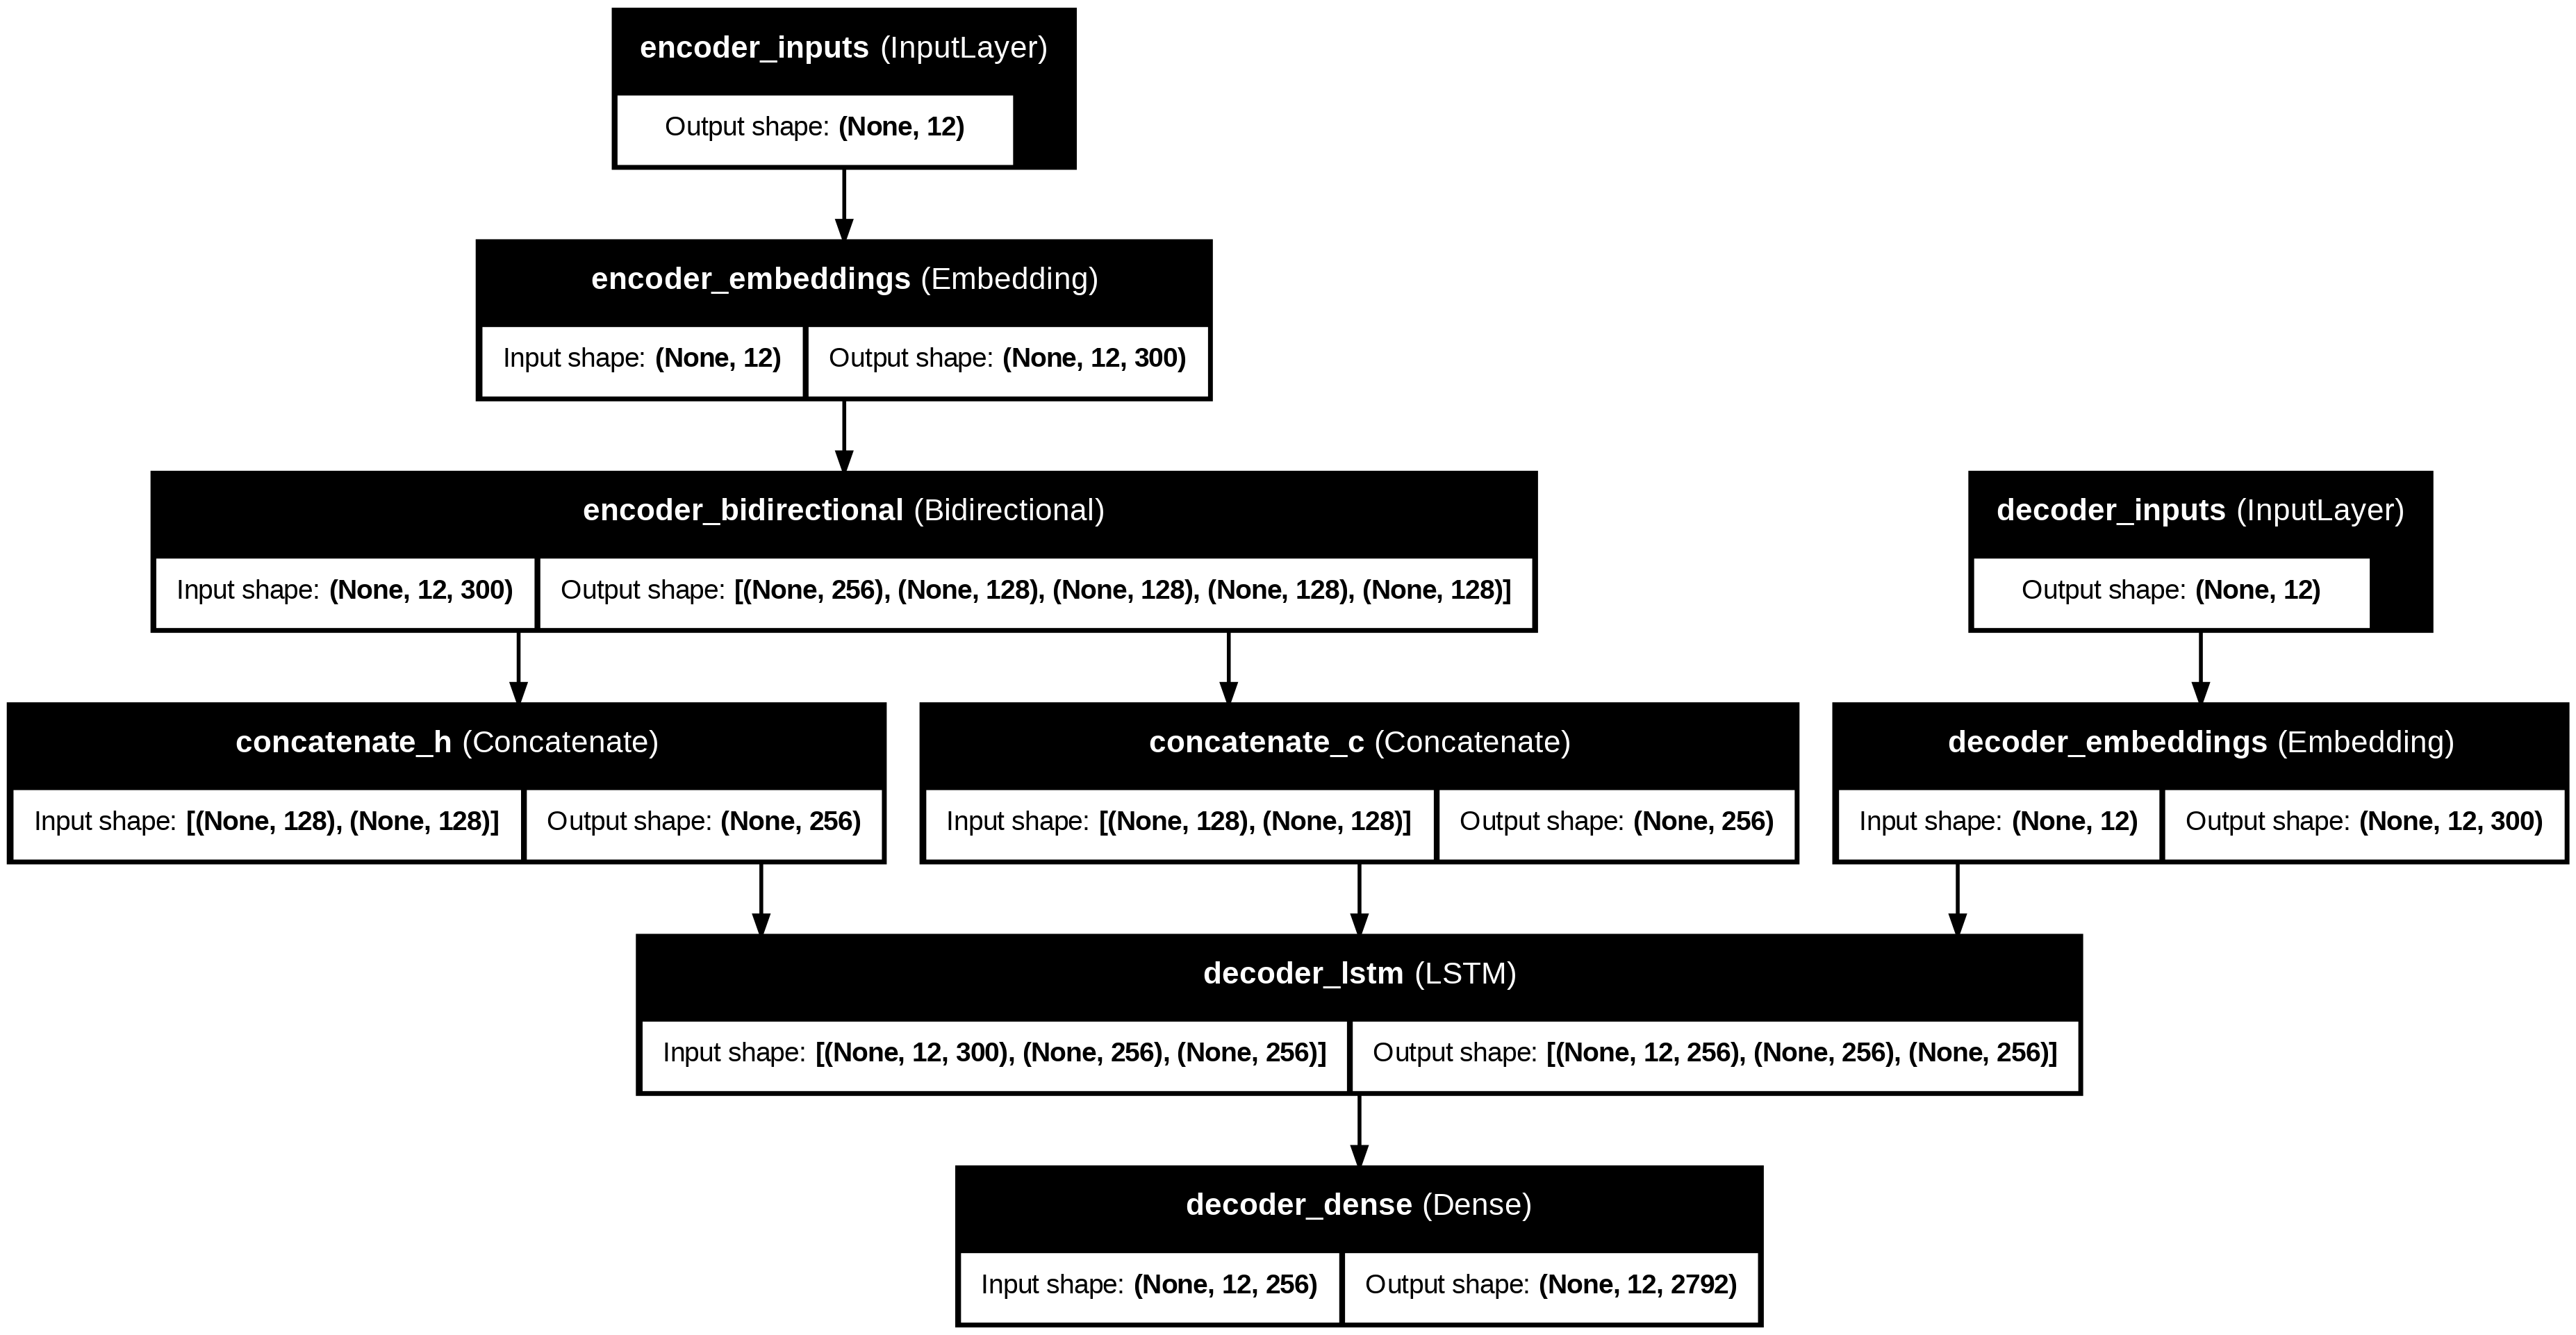

In [37]:
# modelo 1
plot_model(model, to_file='modelo_1_plot.png', show_shapes=True, show_layer_names=True)

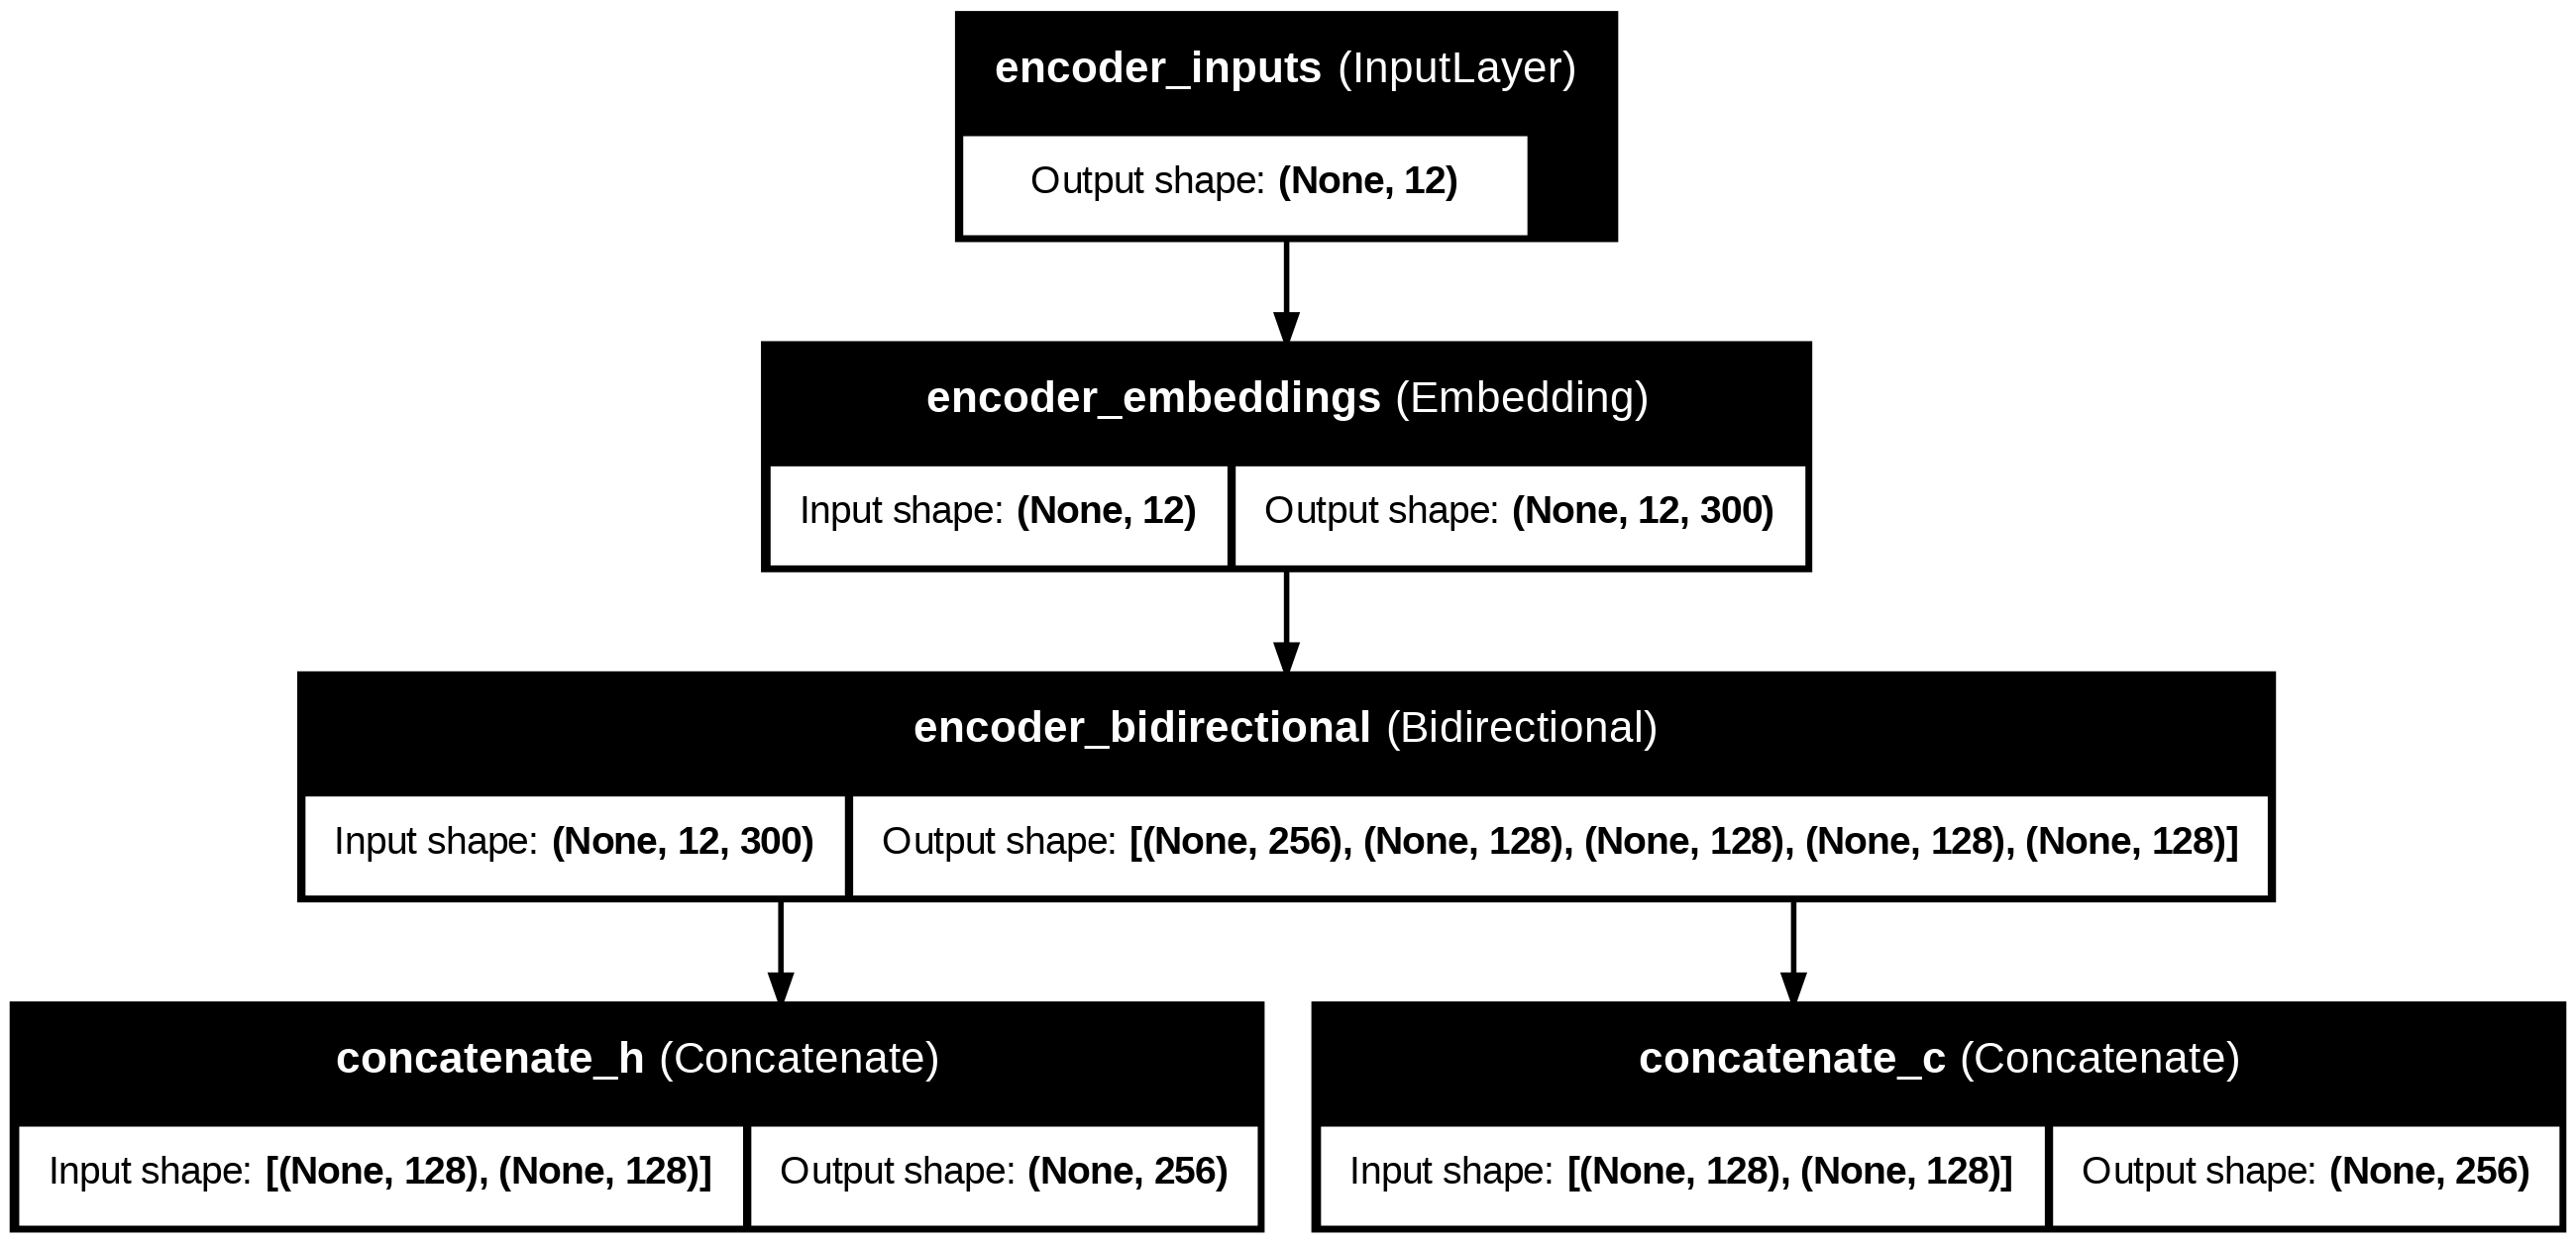

In [38]:
# INFERENCE model: encoder
encoder_model = Model(encoder_inputs, encoder_state)

plot_model(encoder_model, to_file='encoder_1_plot.png', show_shapes=True, show_layer_names=True)

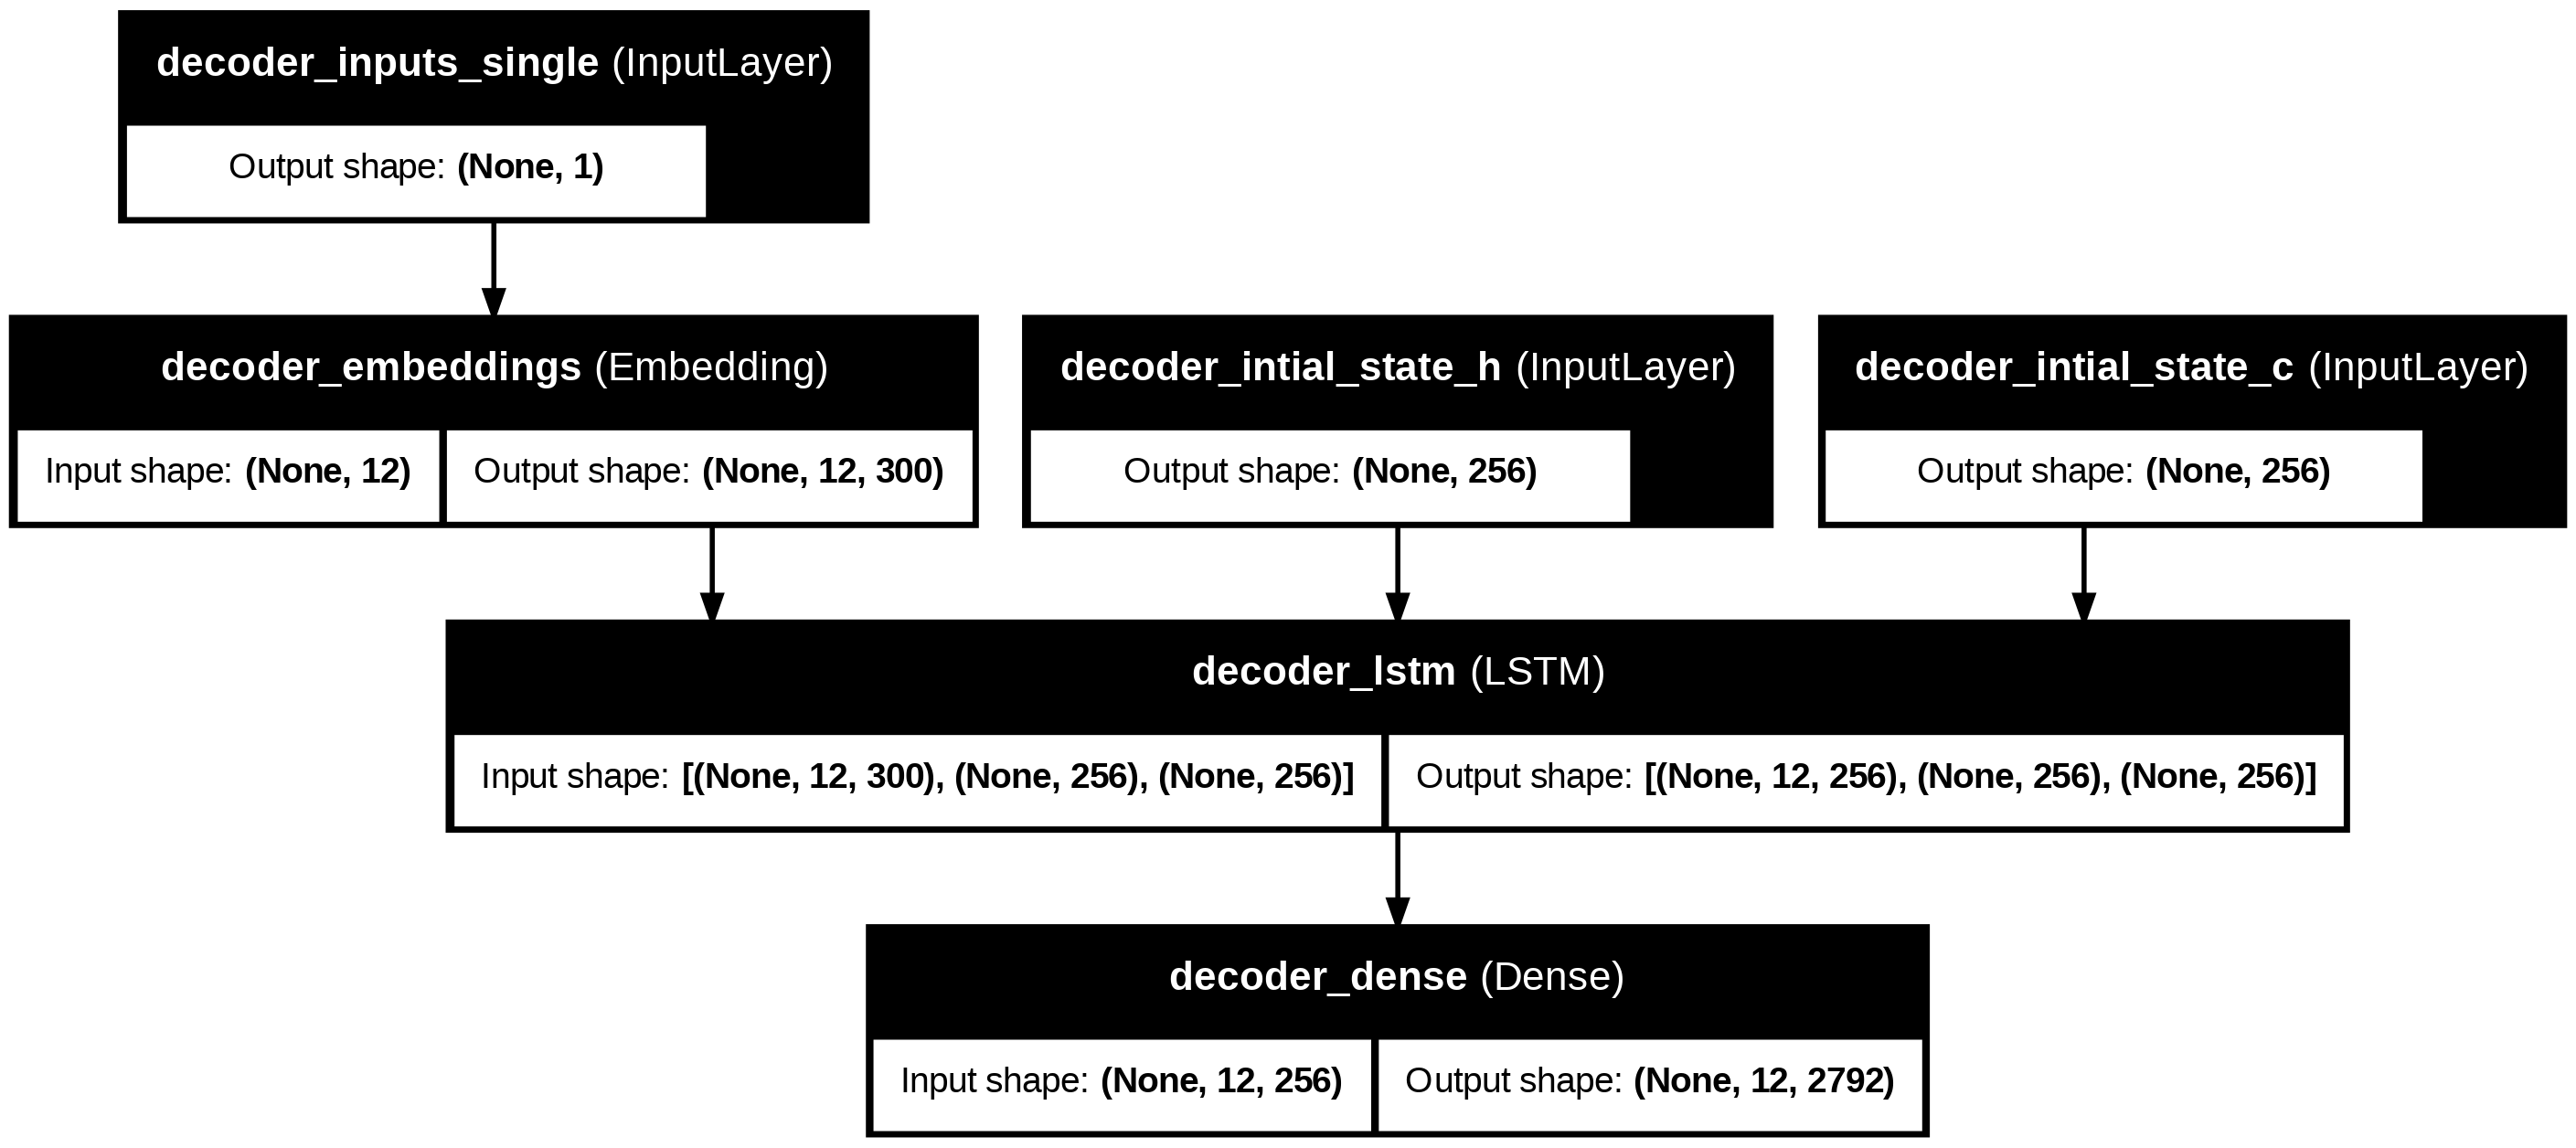

In [39]:
# INFERENCE model: decoder
decoder_initial_state_h = Input(shape=(n_units*2,), name="decoder_intial_state_h")
decoder_initial_state_c = Input(shape=(n_units*2,), name="decoder_intial_state_c")
decoder_initial_state = [decoder_initial_state_h, decoder_initial_state_c]

decoder_inputs_single = Input(shape=(1,), name="decoder_inputs_single") # Single input (word) to decoder
decoder_inputs_embed_single = decoder_embedding_layer(decoder_inputs_single)

decoder_outputs, *decoder_state = decoder_lstm_layer(decoder_inputs_embed_single, initial_state=decoder_initial_state)
decoder_outputs = decoder_dense_layer(decoder_outputs)
decoder_model = Model([decoder_inputs_single] + decoder_initial_state, [decoder_outputs] + decoder_state)

plot_model(decoder_model, to_file='decoder_1_plot.png', show_shapes=True, show_layer_names=True)

In [40]:
# Define LearningRateScheduler callback
def lr_schedule(epoch, lr):
    if lr < 3e-4:
      return lr

    if (epoch + 1) % 10 == 0:
      return lr / 3
    else:
      return lr

lr_scheduler = LearningRateScheduler(lr_schedule)


# Define EarlyStopping callback
early_stopping = EarlyStopping(
    monitor='val_accuracy',  # Monitor validation acc
    patience=5,          # Stop after 3 epochs of no improvement
    restore_best_weights=True,
    verbose=1
)

# Fit the model with EarlyStopping
hist = model.fit(
    [in_encoder_pad, in_decoder_pad],
    out_decoder_ohot,
    epochs=50,
    validation_split=0.2,
    callbacks=[early_stopping, lr_scheduler]
)

Epoch 1/50
216/216 ━━━━━━━━━━━━━━━━━━━━ 37s 124ms/step - accuracy: 0.5628 - loss: 3.1749 - val_accuracy: 0.6733 - val_loss: 1.9613 - learning_rate: 0.0010
Epoch 2/50
216/216 ━━━━━━━━━━━━━━━━━━━━ 25s 117ms/step - accuracy: 0.6872 - loss: 1.7924 - val_accuracy: 0.6948 - val_loss: 1.8187 - learning_rate: 0.0010
Epoch 3/50
216/216 ━━━━━━━━━━━━━━━━━━━━ 40s 112ms/step - accuracy: 0.7049 - loss: 1.6407 - val_accuracy: 0.6978 - val_loss: 1.7635 - learning_rate: 0.0010
Epoch 4/50
216/216 ━━━━━━━━━━━━━━━━━━━━ 42s 115ms/step - accuracy: 0.7100 - loss: 1.5495 - val_accuracy: 0.7008 - val_loss: 1.7284 - learning_rate: 0.0010
Epoch 5/50
216/216 ━━━━━━━━━━━━━━━━━━━━ 25s 114ms/step - accuracy: 0.7183 - loss: 1.4745 - val_accuracy: 0.7051 - val_loss: 1.7077 - learning_rate: 0.0010
Epoch 6/50
216/216 ━━━━━━━━━━━━━━━━━━━━ 27s 124ms/step - accuracy: 0.7200 - loss: 1.4250 - val_accuracy: 0.7079 - val_loss: 1.6954 - learning_rate: 0.0010
Epoch 7/50
216/216 ━━━━━━━━━━━━━━━━━━━━ 39s 114ms/step - accuracy: 0.7

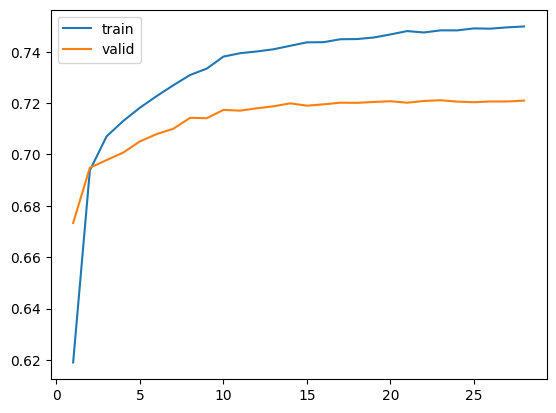

In [41]:
# Metricas Entrenamiento y Validacion
epoch_count = range(1, len(hist.history['accuracy']) + 1)
sns.lineplot(x=epoch_count,  y=hist.history['accuracy'], label='train')
sns.lineplot(x=epoch_count,  y=hist.history['val_accuracy'], label='valid')
plt.show()

In [42]:
encoder_model.save('modelo_1_encoder.keras')
decoder_model.save('modelo_1_decoder.keras')

#### Modelo 2

- Encoder: Capa LSTM bidireccional con 256 neuronas
- Decoder: Capa LSTM con 512 neuronas

In [19]:
n_units = 256

# ENCODER
# Input
encoder_inputs = Input(shape=(max_seq_length,), name="encoder_inputs")

# Embedding
encoder_embedding_layer = Embedding(
          input_dim=vocab_size + 1,  # vocabulary + padding
          output_dim=embed_dim,  # 300 for FastText
          weights=[embedding_matrix],  # includes padding and oov
          trainable=False,
          name="encoder_embeddings"
          )
encoder_inputs_embed = encoder_embedding_layer(encoder_inputs)

# Bidirectional
encoder_lstm_layer = Bidirectional(LSTM(
    n_units,
    return_state=True,
    dropout=0.2,
    recurrent_dropout=0.2,
    name="encoder_LSTM"
    ), name="encoder_bidirectional")
_, forw_h, forw_c, back_h, back_c = encoder_lstm_layer(encoder_inputs_embed)

# Concat
encoder_concat_h_layer = Concatenate(name="concatenate_h")
state_h = encoder_concat_h_layer([forw_h, back_h])
encoder_concat_c_layer = Concatenate(name="concatenate_c")
state_c = encoder_concat_c_layer([forw_c, back_c])
encoder_state = [state_h, state_c]

# DECODER
# Input
decoder_inputs = Input(shape=(max_seq_length,), name="decoder_inputs")

# Embedding
decoder_embedding_layer = Embedding(
          input_dim=vocab_size + 1,  # vocabulary + padding
          output_dim=embed_dim,  # 300 for FastText
          weights=[embedding_matrix],  # includes padding and oov
          trainable=False,
          name="decoder_embeddings"
          )
decoder_inputs_embed = decoder_embedding_layer(decoder_inputs)

# LSTM
decoder_lstm_layer = LSTM(
    n_units*2,
    return_sequences=True,
    return_state=True,
    dropout=0.2,
    recurrent_dropout=0.2,
    name="decoder_lstm"
    )
decoder_outputs, *_ = decoder_lstm_layer(decoder_inputs_embed, initial_state=encoder_state)

# Dense
decoder_dense_layer = Dense(
    vocab_size,
    activation='softmax',
    name="decoder_dense"
    )
decoder_outputs = decoder_dense_layer(decoder_outputs)

model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

optimizer = Nadam(learning_rate=0.001)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ encoder_inputs      │ (None, 12)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_embeddings  │ (None, 12, 300)   │    837,900 │ encoder_inputs[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_inputs      │ (None, 12)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_bidirectio… │ [(None, 512),     │  1,140,736 │ encoder_embeddin… │
│ (Bidirectional)     │ (None, 256),      │            │                   │
│                     │ (None, 256),      │            │                   │
│                     │ (None, 256),      │            │                   │
│                     │ (None, 256)]      │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_embeddings  │ (None, 12, 300)   │    837,900 │ decoder_inputs[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_h       │ (None, 512)       │          0 │ encoder_bidirect… │
│ (Concatenate)       │                   │            │ encoder_bidirect… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_c       │ (None, 512)       │          0 │ encoder_bidirect… │
│ (Concatenate)       │                   │            │ encoder_bidirect… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_lstm (LSTM) │ [(None, 12, 512), │  1,665,024 │ decoder_embeddin… │
│                     │ (None, 512),      │            │ concatenate_h[0]… │
│                     │ (None, 512)]      │            │ concatenate_c[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_dense       │ (None, 12, 2792)  │  1,432,296 │ decoder_lstm[0][… │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 5,913,856 (22.56 MB)

 Trainable params: 4,238,056 (16.17 MB)

 Non-trainable params: 1,675,800 (6.39 MB)

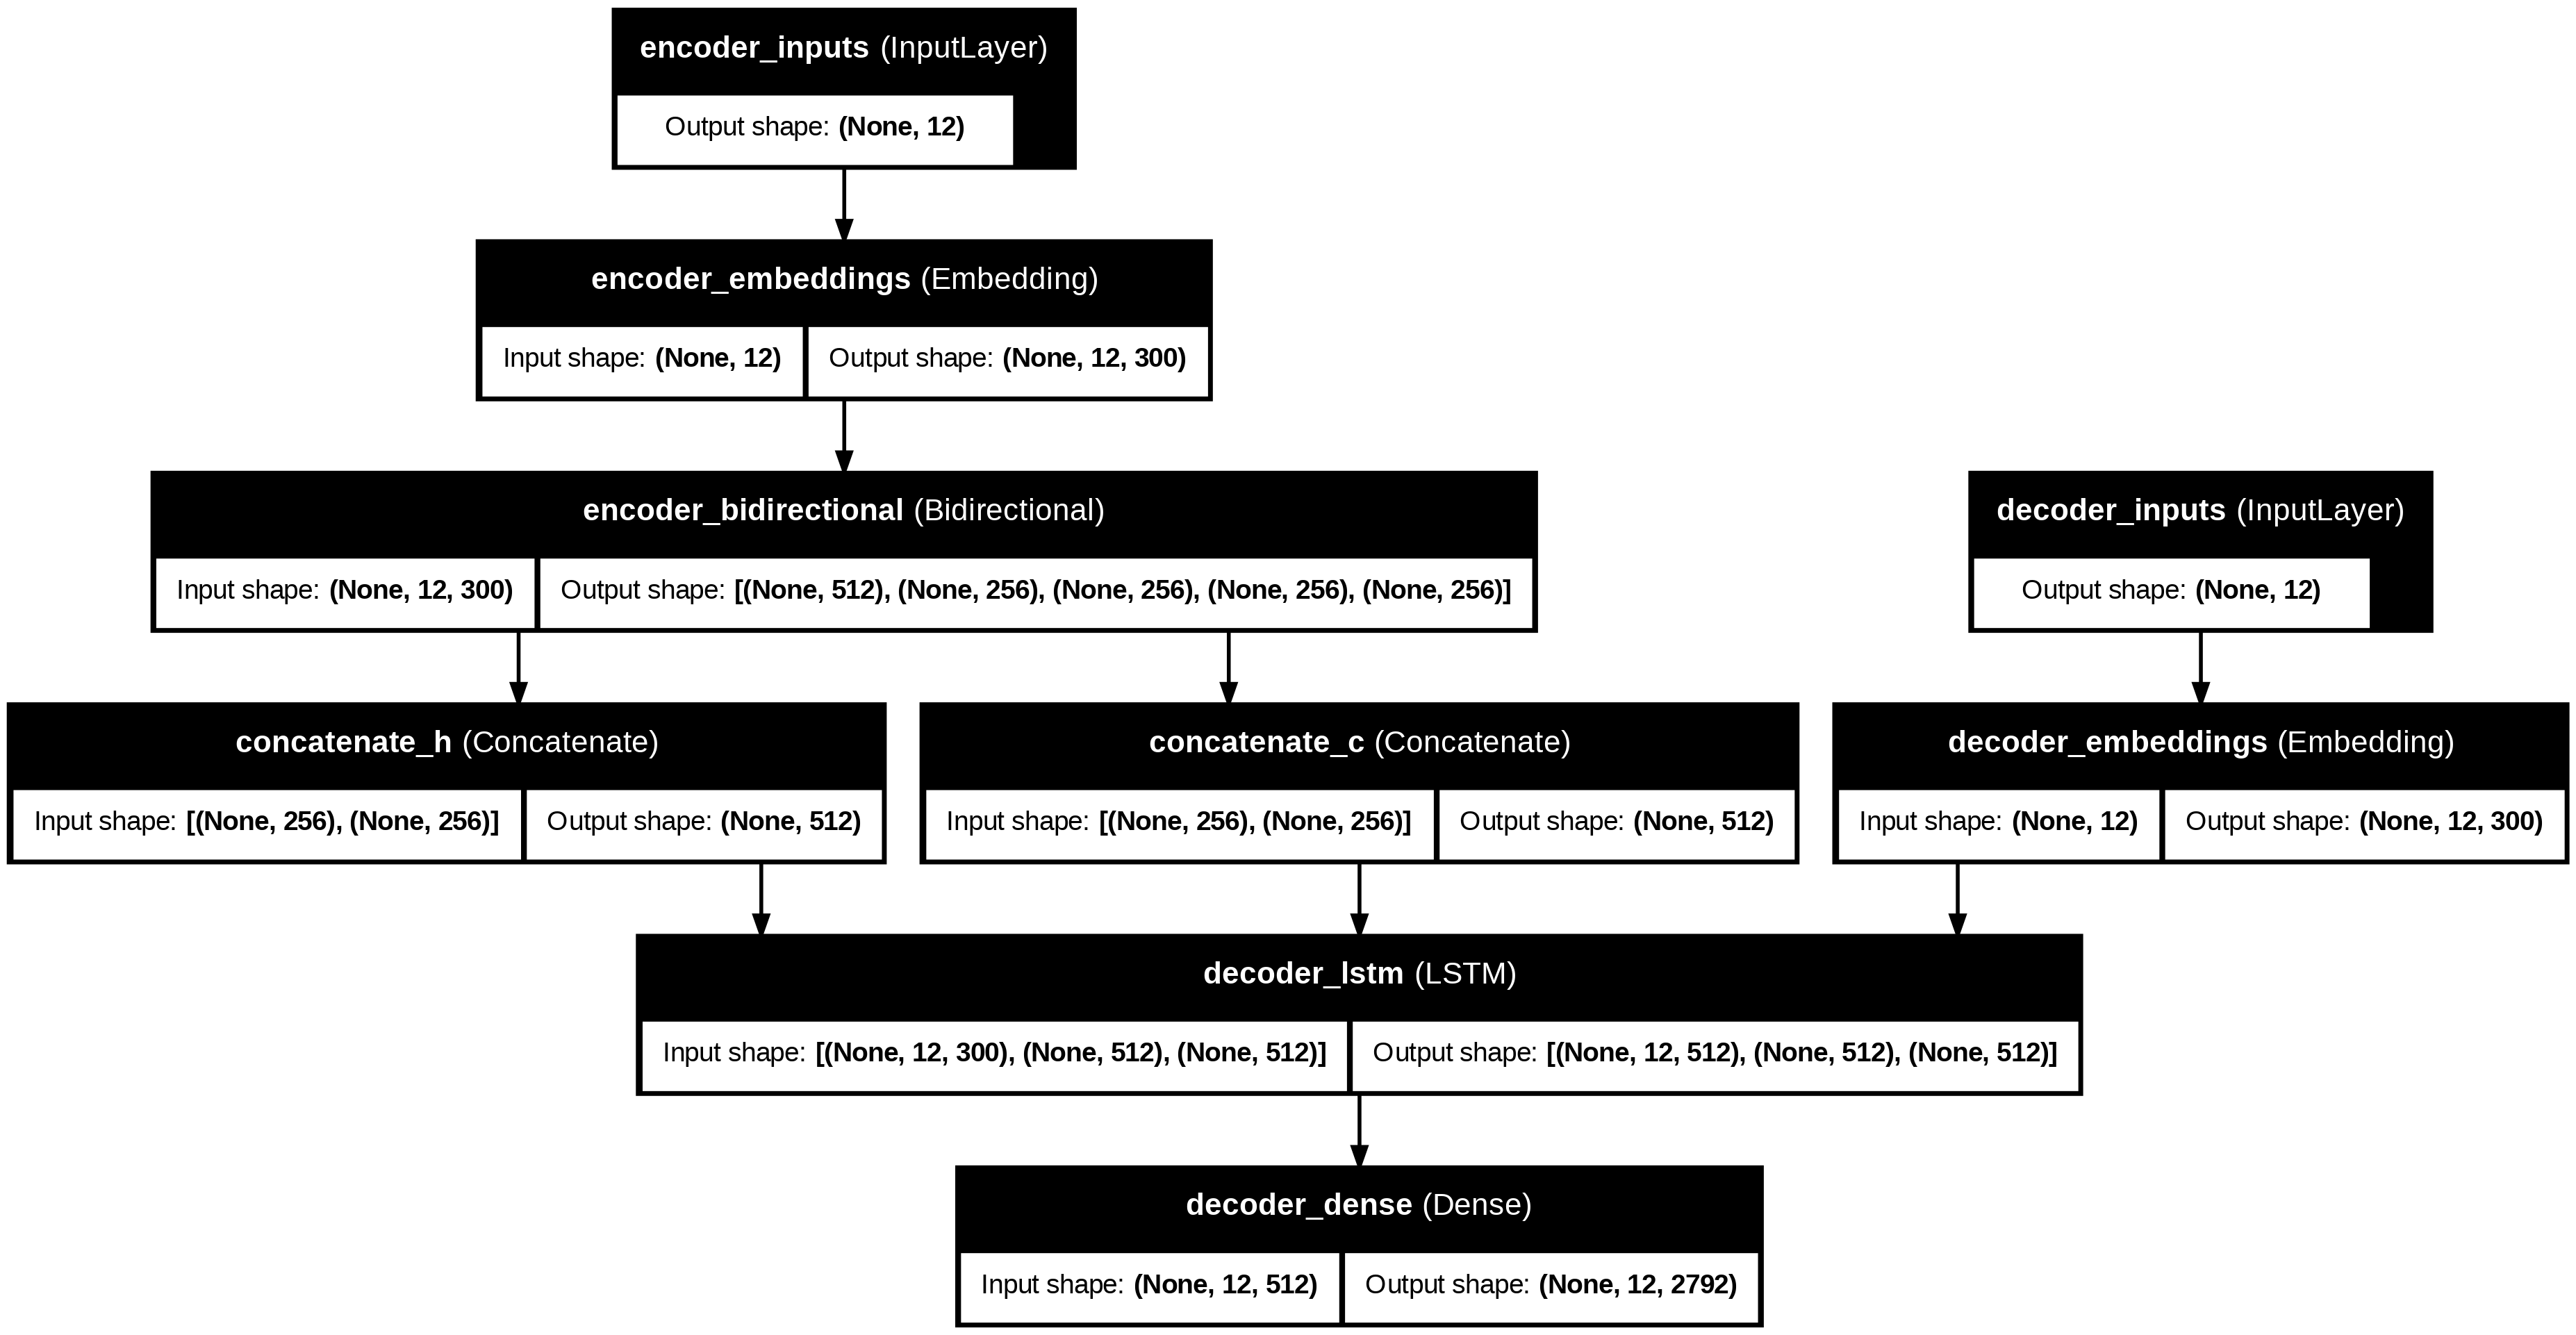

In [20]:
# modelo 2
plot_model(model, to_file='model_2_plot.png', show_shapes=True, show_layer_names=True)

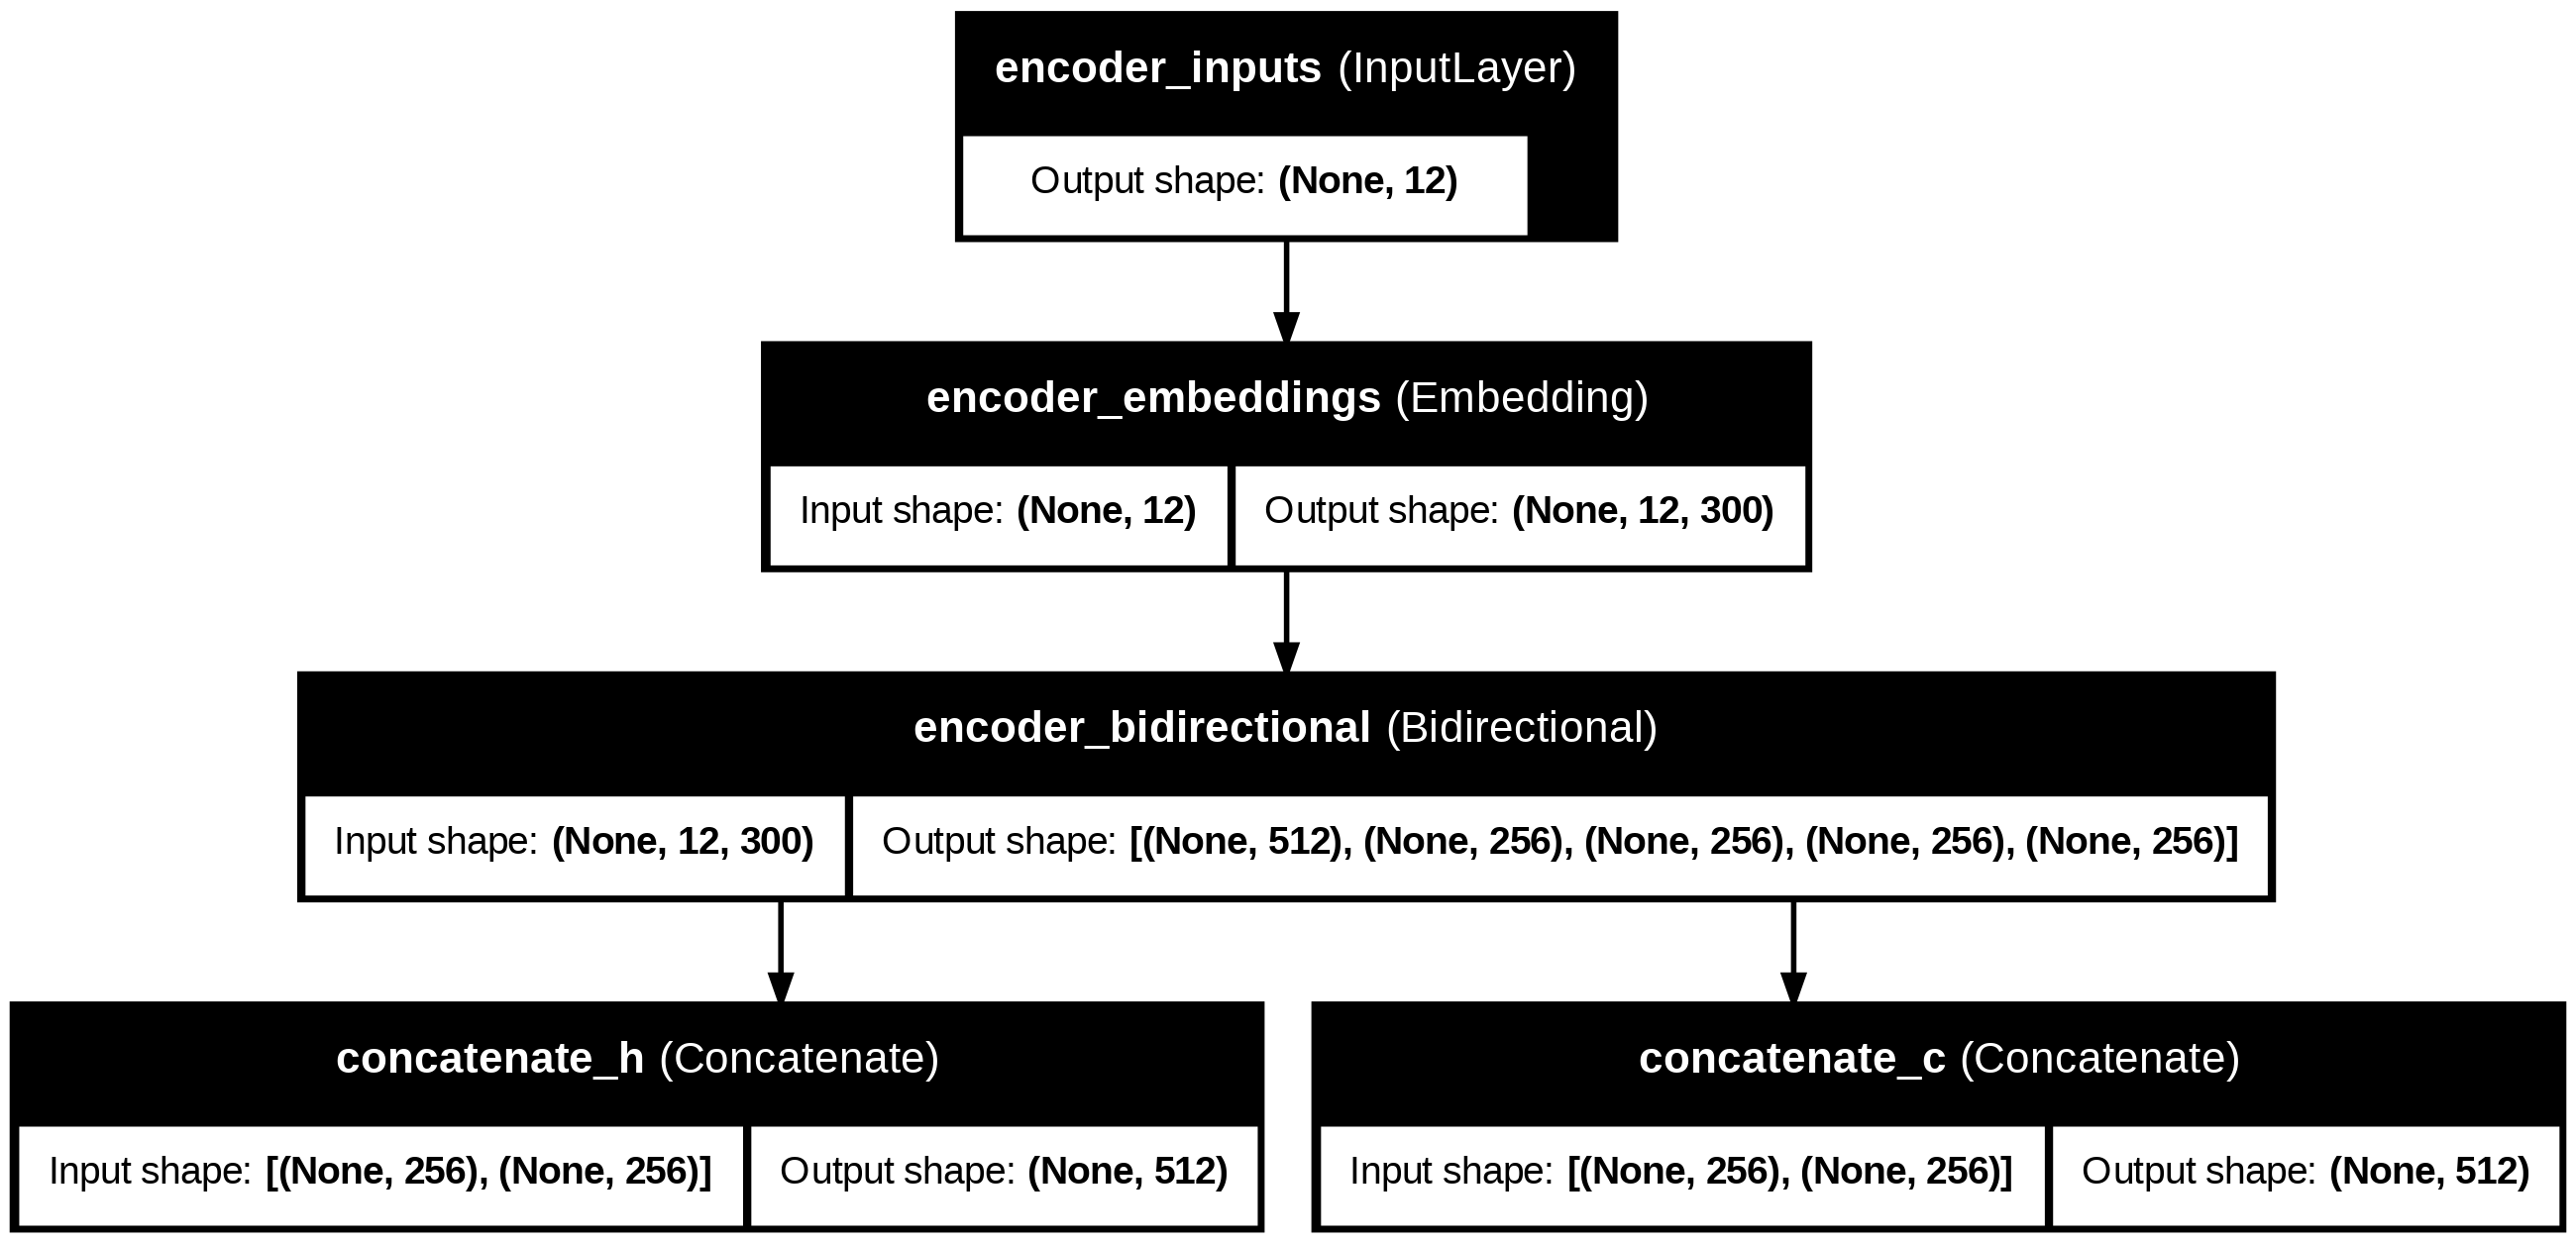

In [21]:
# INFERENCE model: encoder
encoder_model = Model(encoder_inputs, encoder_state)

plot_model(encoder_model, to_file='encoder_2_plot.png', show_shapes=True, show_layer_names=True)

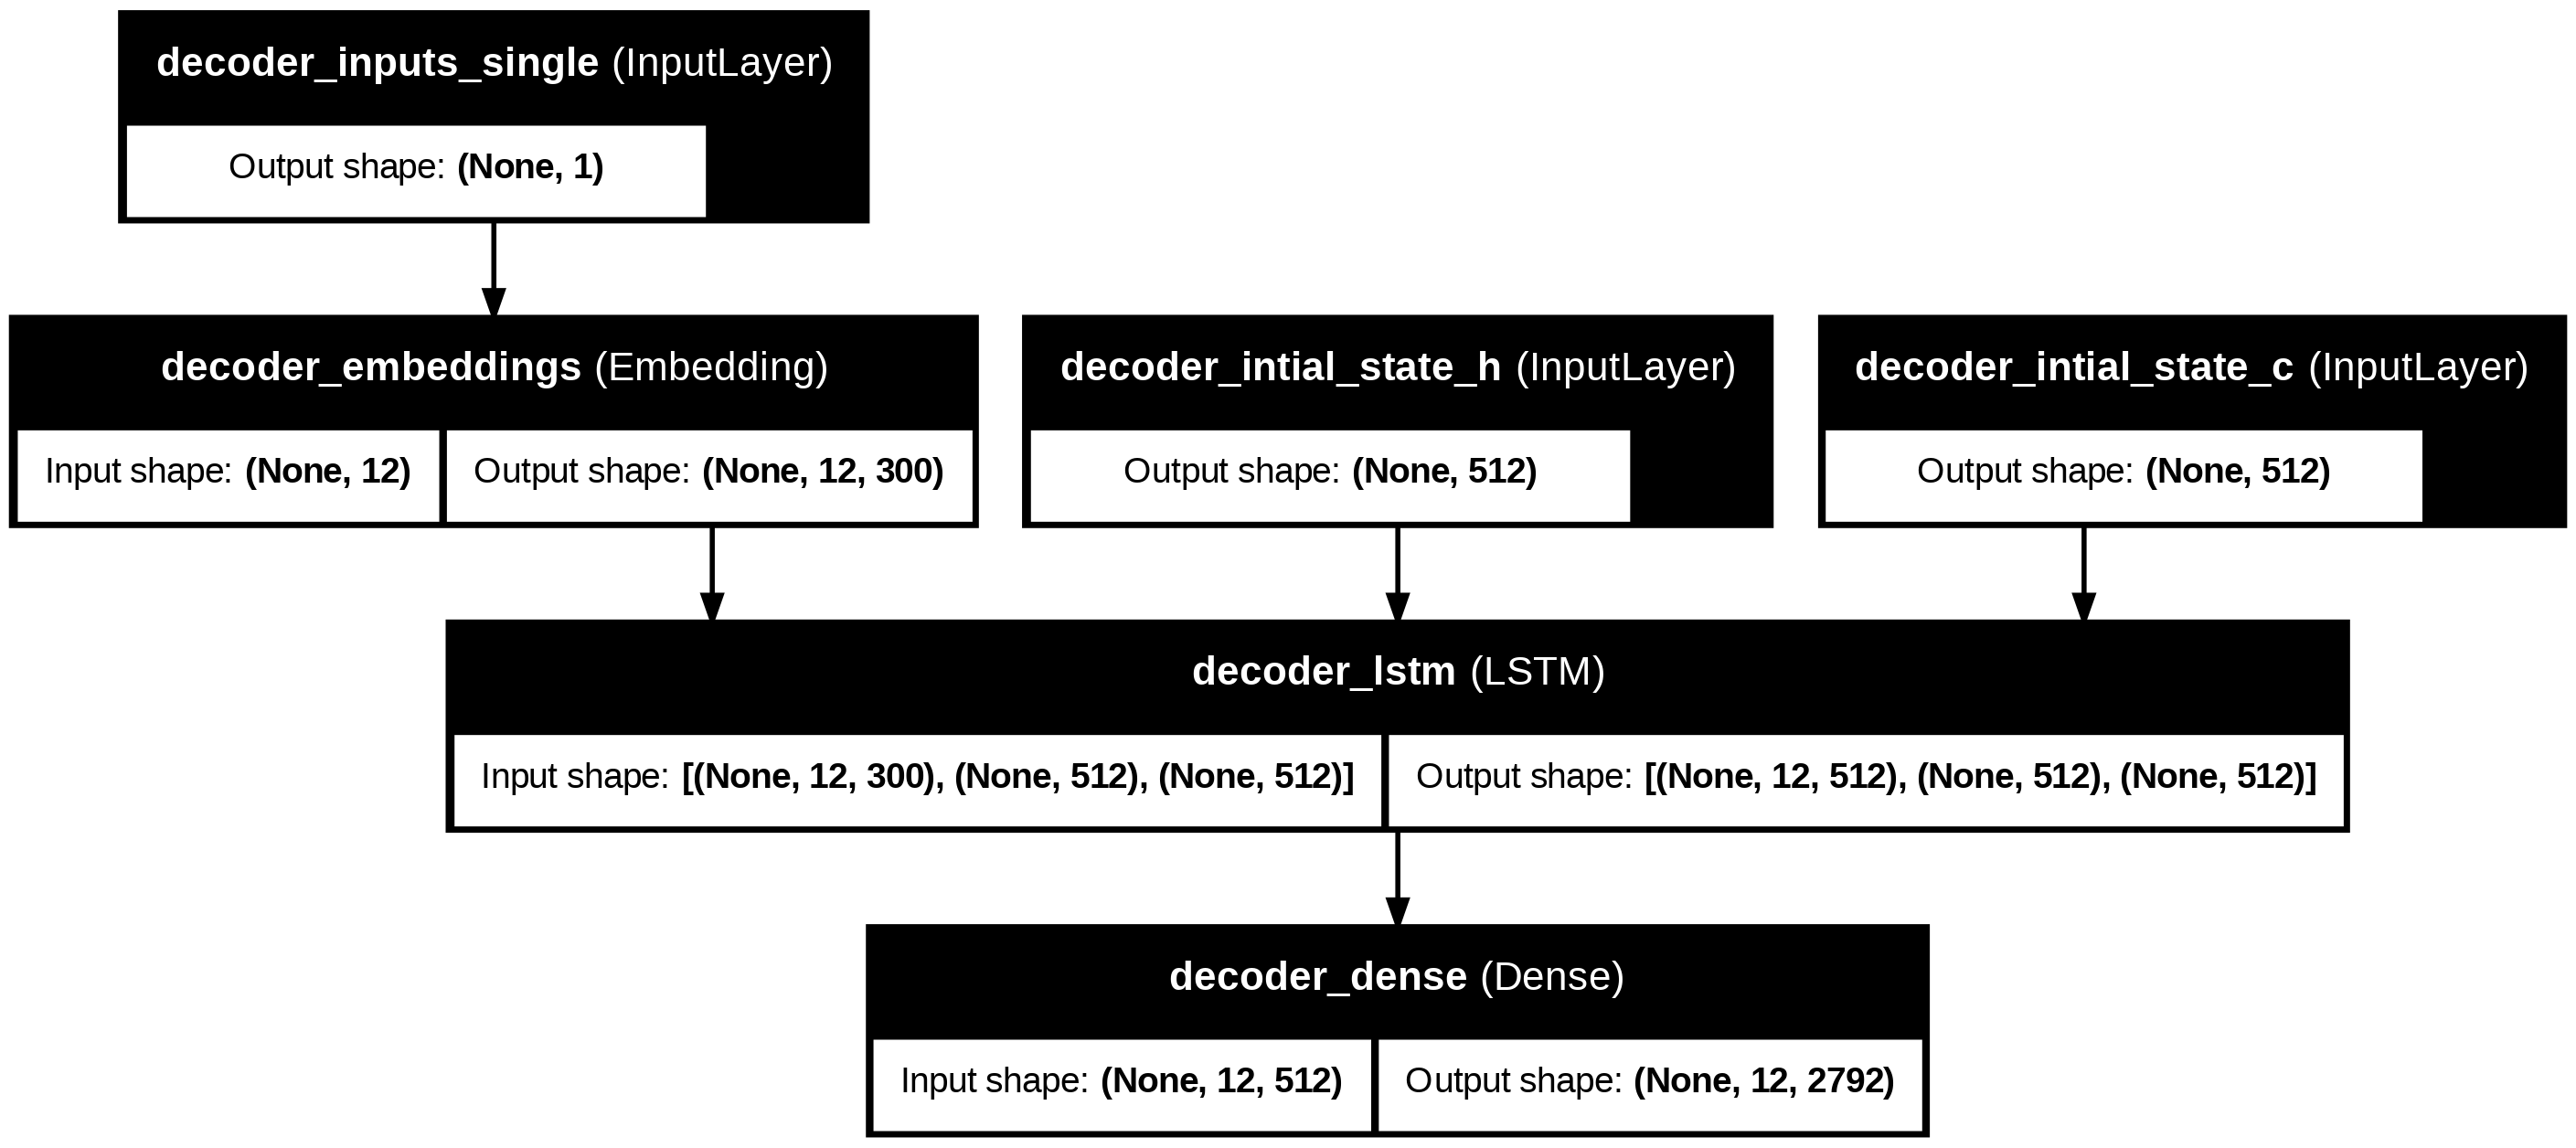

In [22]:
# INFERENCE model: decoder
decoder_initial_state_h = Input(shape=(n_units*2,), name="decoder_intial_state_h")
decoder_initial_state_c = Input(shape=(n_units*2,), name="decoder_intial_state_c")
decoder_initial_state = [decoder_initial_state_h, decoder_initial_state_c]

decoder_inputs_single = Input(shape=(1,), name="decoder_inputs_single") # Single input (word) to decoder
decoder_inputs_embed_single = decoder_embedding_layer(decoder_inputs_single)

decoder_outputs, *decoder_state = decoder_lstm_layer(decoder_inputs_embed_single, initial_state=decoder_initial_state)
decoder_outputs = decoder_dense_layer(decoder_outputs)
decoder_model = Model([decoder_inputs_single] + decoder_initial_state, [decoder_outputs] + decoder_state)

plot_model(decoder_model, to_file='decoder_2_plot.png', show_shapes=True, show_layer_names=True)

In [23]:
# Define LearningRateScheduler callback
def lr_schedule(epoch, lr):
    if lr < 3e-4:
      return lr

    if (epoch + 1) % 10 == 0:
      return lr / 3
    else:
      return lr

lr_scheduler = LearningRateScheduler(lr_schedule)


# Define EarlyStopping callback
early_stopping = EarlyStopping(
    monitor='val_accuracy',  # Monitor validation acc
    patience=5,              # Stop after 3 epochs of no improvement
    restore_best_weights=True,
    verbose=1
)

# Fit the model with EarlyStopping
hist = model.fit(
    [in_encoder_pad, in_decoder_pad],
    out_decoder_ohot,
    epochs=50,
    validation_split=0.2,
    callbacks=[early_stopping, lr_scheduler]
)

Epoch 1/50
216/216 ━━━━━━━━━━━━━━━━━━━━ 42s 131ms/step - accuracy: 0.5938 - loss: 2.7659 - val_accuracy: 0.6893 - val_loss: 1.8361 - learning_rate: 0.0010
Epoch 2/50
216/216 ━━━━━━━━━━━━━━━━━━━━ 35s 123ms/step - accuracy: 0.7049 - loss: 1.6519 - val_accuracy: 0.6980 - val_loss: 1.7436 - learning_rate: 0.0010
Epoch 3/50
216/216 ━━━━━━━━━━━━━━━━━━━━ 40s 117ms/step - accuracy: 0.7168 - loss: 1.5136 - val_accuracy: 0.7073 - val_loss: 1.6962 - learning_rate: 0.0010
Epoch 4/50
216/216 ━━━━━━━━━━━━━━━━━━━━ 42s 122ms/step - accuracy: 0.7283 - loss: 1.3889 - val_accuracy: 0.7120 - val_loss: 1.6667 - learning_rate: 0.0010
Epoch 5/50
216/216 ━━━━━━━━━━━━━━━━━━━━ 41s 122ms/step - accuracy: 0.7348 - loss: 1.3165 - val_accuracy: 0.7150 - val_loss: 1.6528 - learning_rate: 0.0010
Epoch 6/50
216/216 ━━━━━━━━━━━━━━━━━━━━ 40s 120ms/step - accuracy: 0.7403 - loss: 1.2443 - val_accuracy: 0.7159 - val_loss: 1.6608 - learning_rate: 0.0010
Epoch 7/50
216/216 ━━━━━━━━━━━━━━━━━━━━ 40s 116ms/step - accuracy: 0.7

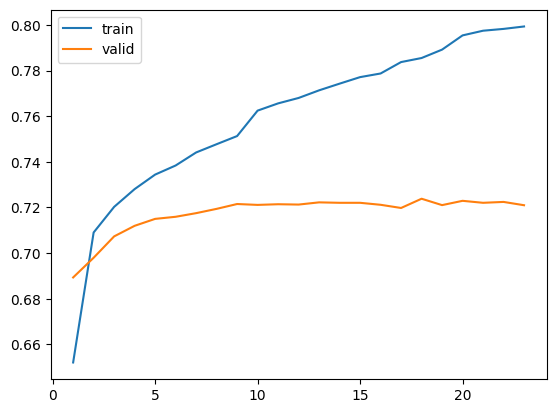

In [26]:
# Entrenamiento
epoch_count = range(1, len(hist.history['accuracy']) + 1)
sns.lineplot(x=epoch_count,  y=hist.history['accuracy'], label='train')
sns.lineplot(x=epoch_count,  y=hist.history['val_accuracy'], label='valid')
plt.show()

In [27]:
encoder_model.save('modelo_2_encoder.keras')
decoder_model.save('modelo_2_decoder.keras')

### 5 - Inferencia

In [28]:
# Define inference function
idx2word = {v:k for k, v in word2idx.items()}

def give_response(input_txt, tok, max_input_len):
    input_seq = tok.texts_to_sequences([input_txt])[0]
    input_pad = pad_sequences([input_seq], maxlen=max_input_len)

    # Obtain initial encoder state
    state_value = encoder_model.predict(input_pad)

    # Initialize decoder with <sos> token
    target_seq = np.zeros((1, 1))
    target_seq[0, 0] = word2idx['sostok']

    # Obtain <eos> token idx
    eos = word2idx['eostok']

    output_sentence = []
    for _ in range(10):
        # predict next element
        output_tokens, h, c = decoder_model.predict([target_seq] + state_value)
        idx = np.argmax(output_tokens[0, 0, :])

        if eos == idx:
            break

        # Convert idx to word
        if idx > 0:
            word = idx2word[idx]
            output_sentence.append(word)

        # Update state with last prediction
        state_value = [h, c]

        # Update decoder input sequence
        target_seq[0, 0] = idx

    return ' '.join(output_sentence)

#### Inferencia Modelo 1

In [60]:
# Load the model
encoder_model = load_model('modelo_1_encoder.keras')
decoder_model = load_model('modelo_1_decoder.keras')

In [61]:
input_txt = "What is your name?"
response = give_response(input_txt, tok, max_input_len)

print('\n')
print('Input:', input_txt)
print('Response:', response)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 672ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 341ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


Input: What is your name?
Response: i am a teacher


In [44]:
input_txt = "Do you read?"
response = give_response(input_txt, tok, max_input_len)

print('\n')
print('Input:', input_txt)
print('Response:', response)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


Input: Do you read?
Response: i do not have a lot of time for that


In [45]:
input_txt = "Do you have any pet?"
response = give_response(input_txt, tok, max_input_len)

print('\n')
print('Input:', input_txt)
print('Response:', response)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


Input: Do you have any pet?
Response: i do not have a lot of time for that


In [46]:
input_txt = "Where are you from?"
response = give_response(input_txt, tok, max_input_len)

print('\n')
print('Input:', input_txt)
print('Response:', response)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


Input: Where are you from?
Response: i am not sure what you mean


#### Inferencia Modelo 2

In [54]:
# Load the model
encoder_model = load_model('modelo_2_encoder.keras')
decoder_model = load_model('modelo_2_decoder.keras')

In [59]:
input_txt = "What is your name?"
response = give_response(input_txt, tok, max_input_len)

print('\n')
print('Input:', input_txt)
print('Response:', response)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


Input: What is your name?
Response: my name is lucy what is yours


In [31]:
input_txt = "Do you read?"
response = give_response(input_txt, tok, max_input_len)

print('\n')
print('Input:', input_txt)
print('Response:', response)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Input: Do you read?
Response: i do not have any lot of time for that


In [32]:
input_txt = "Do you have any pet?"
response = give_response(input_txt, tok, max_input_len)

print('\n')
print('Input:', input_txt)
print('Response:', response)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Input: Do you have any pet?
Response: no


In [33]:
input_txt = "Where are you from?"
response = give_response(input_txt, tok, max_input_len)

print('\n')
print('Input:', input_txt)
print('Response:', response)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


Input: Where are you from?
Response: i am from california how about you
